# Предсказание рисков сердечного приступа

# Импорт библиотек

In [3]:
import pandas as pd
import re
import numpy as np
import math

import sklearn
from sklearn.ensemble import GradientBoostingClassifier, AdaBoostClassifier, HistGradientBoostingClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from catboost import CatBoostClassifier
from xgboost import XGBRFClassifier

from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.metrics import f1_score, confusion_matrix, precision_score, recall_score, accuracy_score, roc_auc_score
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler, OrdinalEncoder, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer

import matplotlib.pyplot as plt
import seaborn as sns
import phik

TEST_SIZE = 0.2
RANDOM_STATE = 42

pd.set_option('display.max_columns', None)

# Загрузка данных

In [5]:
train_data = pd.read_csv('./datasets/heart_train.csv')
train_data.head()

,Unnamed: 0,Age,Cholesterol,Heart rate,Diabetes,Family History,Smoking,Obesity,Alcohol Consumption,Exercise Hours Per Week,Diet,Previous Heart Problems,Medication Use,Stress Level,Sedentary Hours Per Day,Income,BMI,Triglycerides,Physical Activity Days Per Week,Sleep Hours Per Day,Heart Attack Risk (Binary),Blood sugar,CK-MB,Troponin,Gender,Systolic blood pressure,Diastolic blood pressure,id
0,0,0.359551,0.732143,0.074244,1.0,1.0,1.0,1.0,1.0,0.535505,1,1.0,0.0,8.0,0.225704,0.105948,0.459176,0.979221,3.0,0.333333,0.0,0.227018,0.048229,0.036512,Male,0.212903,0.709302,2664
1,1,0.202247,0.325000,0.047663,1.0,1.0,0.0,0.0,1.0,0.068690,2,1.0,0.0,9.0,0.289923,0.164217,0.117053,0.515584,3.0,0.833333,0.0,0.150198,0.017616,0.000194,Female,0.412903,0.569767,9287
2,2,0.606742,0.860714,0.055912,1.0,0.0,1.0,1.0,1.0,0.944001,2,1.0,1.0,6.0,0.550133,0.598745,0.373574,0.012987,2.0,1.000000,0.0,0.227018,0.048229,0.036512,Female,0.238710,0.220930,5379
3,3,0.730337,0.007143,0.053162,0.0,0.0,1.0,0.0,1.0,0.697023,0,0.0,1.0,3.0,0.330962,0.077605,0.049735,0.131169,0.0,0.333333,1.0,0.227018,0.048229,0.036512,Female,0.348387,0.267442,8222
4,4,0.775281,0.757143,0.021998,0.0,0.0,1.0,0.0,1.0,0.412878,1,0.0,0.0,8.0,0.524600,0.341960,0.830405,0.070130,5.0,1.000000,1.0,0.227018,0.048229,0.036512,Male,0.619355,0.441860,4047


In [6]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8685 entries, 0 to 8684
Data columns (total 28 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   Unnamed: 0                       8685 non-null   int64  
 1   Age                              8685 non-null   float64
 2   Cholesterol                      8685 non-null   float64
 3   Heart rate                       8685 non-null   float64
 4   Diabetes                         8442 non-null   float64
 5   Family History                   8442 non-null   float64
 6   Smoking                          8442 non-null   float64
 7   Obesity                          8442 non-null   float64
 8   Alcohol Consumption              8442 non-null   float64
 9   Exercise Hours Per Week          8685 non-null   float64
 10  Diet                             8685 non-null   int64  
 11  Previous Heart Problems          8442 non-null   float64
 12  Medication Use      

In [7]:
train_data.describe()

,Unnamed: 0,Age,Cholesterol,Heart rate,Diabetes,Family History,Smoking,Obesity,Alcohol Consumption,Exercise Hours Per Week,Diet,Previous Heart Problems,Medication Use,Stress Level,Sedentary Hours Per Day,Income,BMI,Triglycerides,Physical Activity Days Per Week,Sleep Hours Per Day,Heart Attack Risk (Binary),Blood sugar,CK-MB,Troponin,Systolic blood pressure,Diastolic blood pressure,id
count,8685.000000,8685.000000,8685.000000,8685.000000,8442.000000,8442.000000,8442.000000,8442.000000,8442.000000,8685.000000,8685.000000,8442.000000,8442.000000,8442.000000,8685.000000,8685.000000,8685.000000,8685.000000,8442.000000,8685.000000,8685.000000,8685.000000,8685.000000,8685.000000,8685.000000,8685.000000,8685.000000
mean,4342.000000,0.449958,0.501070,0.050658,0.652097,0.489576,0.902867,0.498342,0.601990,0.503378,1.057455,0.495380,0.501185,5.493367,0.499164,0.496055,0.496774,0.505484,3.508292,0.503737,0.346920,0.227339,0.048159,0.036689,0.450295,0.497634,4831.210823
std,2507.287877,0.231174,0.284716,0.023453,0.476333,0.499921,0.296157,0.500027,0.489517,0.284810,0.866645,0.500008,0.500028,2.867862,0.285340,0.284698,0.282561,0.286320,2.281772,0.328061,0.476017,0.076635,0.075531,0.060157,0.170184,0.171830,2782.585625
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,2171.000000,0.258427,0.267857,0.034830,0.000000,0.000000,1.000000,0.000000,0.000000,0.263286,0.000000,0.000000,0.000000,3.000000,0.255875,0.251922,0.254190,0.263636,2.000000,0.166667,0.000000,0.227018,0.048229,0.036512,0.303226,0.348837,2425.000000
50%,4342.000000,0.460674,0.499780,0.050412,1.000000,0.000000,1.000000,0.000000,1.000000,0.502110,1.000000,0.000000,1.000000,5.000000,0.499920,0.494889,0.494774,0.503603,3.000000,0.500000,0.000000,0.227018,0.048229,0.036512,0.445161,0.500000,4837.000000
75%,6513.000000,0.640449,0.746429,0.065995,1.000000,1.000000,1.000000,1.000000,1.000000,0.748709,2.000000,1.000000,1.000000,8.000000,0.744623,0.741036,0.736974,0.750649,6.000000,0.833333,1.000000,0.227018,0.048229,0.036512,0.600000,0.651163,7242.000000
max,8684.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,3.000000,1.000000,1.000000,10.000000,1.000000,1.000000,1.000000,1.000000,7.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,9650.000000


# Изучим признаки

## age - возраст
- Возможные значения: от 0 до 1.
- Действительные числа.
- Возраст вполне может коррелировать с целевым признаком.

## cholesterol - уровень холестерина
- Возможные значения: от 0 до 1.
- Действительные числа.
- Уровень холестерина может коррелировать с целевым признаком.

## heart_rate - частота сердечных сокращений
- Возможные значения: от 0 до 1.
- Действительные числа.
- Уровень холестерина может коррелировать с целевым признаком.

## <span style="color:orange">diabetes - сахарный диабет</span>
- Возможные значения: 0, 1, NaN.
- Есть пропуски.
- Вероятно бинарный признак (1 - есть диабет, 0 - нет диабета).
- Сахарный диабет может коррелировать с целевым признаком.

## <span style="color:red">family_history - медицинская история о родственниках</span>
- Возможные значения: 0, 1, NaN.
- Есть пропуски.
- Вероятно бинарный признак (1 - есть история, 0 - нет истории).
- Медицинская история родственников может уточнить возможную предрасположенность к ряду заболеваний, но прямым образом наличие истории никак не может влиять на вероятность сердечного приступа. Признак будет отброшен.

## <span style="color:orange">smoking - курение</span>
- Возможные значения: 0, 1, NaN.
- Есть пропуски.
- Вероятно бинарный признак (1 - есть привычка, 0 - нет привычки).
- Курение может коррелировать с целевым признаком.

## <span style="color:orange">obesity - ожирение</span>
- Возможные значения: 0, 1, NaN.
- Есть пропуски.
- Вероятно бинарный признак (1 - есть ожирение, 0 - нет ожирения).
- Ожирение может коррелировать с целевым признаком.

## <span style="color:orange">alcohol_consumption - употребление алкоголя</span>
- Возможные значения: 0, 1, NaN.
- Есть пропуски.
- Вероятно бинарный признак (1 - есть привычка, 0 - нет привычки).
- Прием алкоголя может нелинейно коррелировать с целевым признаком, т.к. большое значение будет иметь количество употребляемого алкоголя, нежели сам факт.

## exercise_hours_per_week - количество часов в неделю, уделяемых физическим упражнениям
- Возможные значения: от 0 до 1.
- Действительные числа.
- Занятия спортом могут иметь обратную корреляцию с целевым признаком.

## <span style="color:red">diet - диета</span>
- Возможные значения: 0, 1, 2, 3.
- Вероятно целочисленное обозначение типа диеты.
- Диета, назначенная в медицинских целях, скорее всего является результатом уже имеющихся проблем со здоровьем. Какой-либо вариант диеты может скорее являться утечкой целевого признака, нежели коррелятом. Отбросим данный признак.

## <span style="color:red">previous_heart_problems - проблемы с сердцем в прошлом</span>
- Возможные значения: 0, 1, NaN.
- Есть пропуски.
- Вероятно бинарный признак (1 - были проблемы, 0 - не было проблем).
- Наличие проблем с сердцем в прошлом имеет явно сильную корреляцию с целевым признаком. Стоило бы разбить пациентов на отдельные группы по данному признаку.

## <span style="color:orange">medication_use - прием лекарств</span>
- Возможные значения: 0, 1, NaN.
- Есть пропуски.
- Вероятно бинарный признак (1 - принимает, 0 - не принимает).
- Сомнительный признак, т.к. факт приема лекарств (не известно каких) не может приближать или отдалять пациента от возможного сердечного приступа. Стоит отказаться от данного признака. Возможно будет найдена корреляция между приемом лекарств и пациентами, подверженными различным заболеваниям, что косвенно будет указывать и на сердечный приступ.

## <span style="color:orange">stress_level - уровень стресса</span>
- Возможные значения: от 1 до 10, NaN.
- Есть пропуски.
- Вероятно категориальное распределение (1 - низкий уровень стресса, 10 - высокий уровень стресса).
- Уровень стресса может коррелировать с целевым признаком.

## sedentary_hours_per_day - количество "сидячих" часов в день
- Возможные значения: от 0 до 1.
- Действительные числа.
- Количество "сидячих" часов в день может коррелировать с целевым признаком.

## <span style="color:red">income - уровень дохода</span>
- Возможные значения: от 0 до 1.
- Действительные числа.
- Однозначно уровень дохода никак не может быть связан с вероятностью возникновения сердечного приступа. Признак будет отброшен.

## bmi - индекс массы тела
- Возможные значения: от 0 до 1.
- Действительные числа.
- Индекс массы тела более точно раскрывает признак "ожирение", и также может коррелировать с целевым признаком. Возможно в будущем будет иметь смысл отказаться от признака "ожирение".

## triglycerides - уровень триглицериды
- Возможные значения: от 0 до 1.
- Действительные числа.
- Уровень триглицеридов может коррелировать с целевым признаком.

## <span style="color:orange">physical_activity_days_per_week - количество дней в неделю, уделяемых физическим упражнениям</span>
- Возможные значения: от 1 до 7, NaN.
- Есть пропуски.
- Занятия спортом могут иметь обратную корреляцию с целевым признаком.

## sleep_hours_per_day - количество часов в день, уделяемых сну
- Возможные значения: от 0 до 1.
- Действительные числа.
- Режим сна может коррелировать с целевым признаком.

## <span style="color:blue">heart_attack_risk_binary - высокий риск сердечного приступа</span>
- <span style="color:blue">Целевой признак!</span>
- Возможные значения: 0, 1.
- Бинарный признак (1 - высокий риск, 0 - низкий риск).

## blood_sugar - уровень сахара в крови
- Возможные значения: от 0 до 1.
- Действительные числа.
- Уровень сахара в крови может коррелировать с целевым признаком.

## ck_mb - креатинкиназа MB
- Возможные значения: от 0 до 1.
- Действительные числа.
- Увеличение концентрации вещества может указывать на повреждение миокарда. Анализ на креатинкиназу-МВ позволяет заподозрить инфаркт миокарда в первые часы от начала приступа и своевременно начать лечебные мероприятия. Может коррелировать с целевым признаком.

## <span style="color:red">troponin - тропонин</span>
- Возможные значения: от 0 до 1.
- Действительные числа.
- Обычно уровень тропонина I в крови настолько низкий, что не может быть измерен. Поэтому даже небольшое повышение может свидетельствовать  о повреждении сердца. Значительно повышенный уровень тропонина I с очень высокой вероятностью свидетельствует об инфаркте миокарда или другом повреждении сердца. Повышается и измеряется при инфаркте. Будет являться утечкой. Отбросим признак.

## gender - пол
- Возможные значения: 0, 1, Male, Female.
- Необходимо привести значения к единой системе.
- Пол может коррелировать с вероятностью возникновения сердечного приступа. Но кажется правильным решением рассматривать мужскую и женскую группу пациентов по отдельности.

## systolic_blood_pressure - систолическое (верхнее) артериальное давление
- Возможные значения: от 0 до 1.
- Действительные числа.
- Гипертония, например, может коррелировать с сердечным приступом.

## diastolic_blood_pressure - диастолическое (нижнее) артериальное давление
- Возможные значения: от 0 до 1.
- Действительные числа.
- Гипертония, например, может коррелировать с сердечным приступом.

# Предобработка данных

In [36]:
def start_preproc(df):
    result_df = df.copy()

    #удаляем столбец, явно содержащий порядковую индексацию по умолчанию
    result_df = result_df.drop(columns=['Unnamed: 0'])
    #проставим id пациентов как индексы датафрейма
    result_df.set_index('id', inplace=True)
    #приведем названия столбцов к "змеиному" стилю
    result_df.rename(columns=lambda x: re.sub(r'[\(\)]', '', re.sub(r'[-\s]', '_', x.lower())), inplace=True)

    return result_df

In [37]:
train_data = start_preproc(train_data)
train_data.head()

,age,cholesterol,heart_rate,diabetes,family_history,smoking,obesity,alcohol_consumption,exercise_hours_per_week,diet,previous_heart_problems,medication_use,stress_level,sedentary_hours_per_day,income,bmi,triglycerides,physical_activity_days_per_week,sleep_hours_per_day,heart_attack_risk_binary,blood_sugar,ck_mb,troponin,gender,systolic_blood_pressure,diastolic_blood_pressure
id,,,,,,,,,,,,,,,,,,,,,,,,,,
2664,0.359551,0.732143,0.074244,1.0,1.0,1.0,1.0,1.0,0.535505,1,1.0,0.0,8.0,0.225704,0.105948,0.459176,0.979221,3.0,0.333333,0.0,0.227018,0.048229,0.036512,Male,0.212903,0.709302
9287,0.202247,0.325000,0.047663,1.0,1.0,0.0,0.0,1.0,0.068690,2,1.0,0.0,9.0,0.289923,0.164217,0.117053,0.515584,3.0,0.833333,0.0,0.150198,0.017616,0.000194,Female,0.412903,0.569767
5379,0.606742,0.860714,0.055912,1.0,0.0,1.0,1.0,1.0,0.944001,2,1.0,1.0,6.0,0.550133,0.598745,0.373574,0.012987,2.0,1.000000,0.0,0.227018,0.048229,0.036512,Female,0.238710,0.220930
8222,0.730337,0.007143,0.053162,0.0,0.0,1.0,0.0,1.0,0.697023,0,0.0,1.0,3.0,0.330962,0.077605,0.049735,0.131169,0.0,0.333333,1.0,0.227018,0.048229,0.036512,Female,0.348387,0.267442
4047,0.775281,0.757143,0.021998,0.0,0.0,1.0,0.0,1.0,0.412878,1,0.0,0.0,8.0,0.524600,0.341960,0.830405,0.070130,5.0,1.000000,1.0,0.227018,0.048229,0.036512,Male,0.619355,0.441860


In [38]:
def my_hist(df, x, hue=None):
    plt.figure(figsize=(15,5))
    if hue != None:
        sns.histplot(data=df, x=x, bins=int(math.log2(len(df))) + 1, palette='pastel', hue=hue)
    else:
        sns.histplot(data=df, x=x, bins=int(math.log2(len(df))) + 1)
    plt.ylabel('Частота')
    plt.title('Гистограмма')
    plt.show()

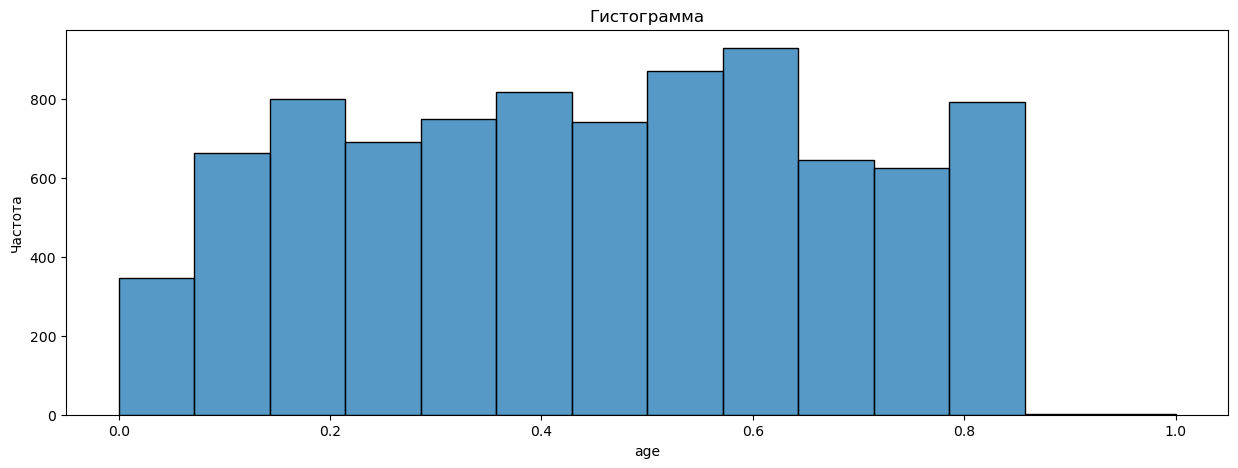

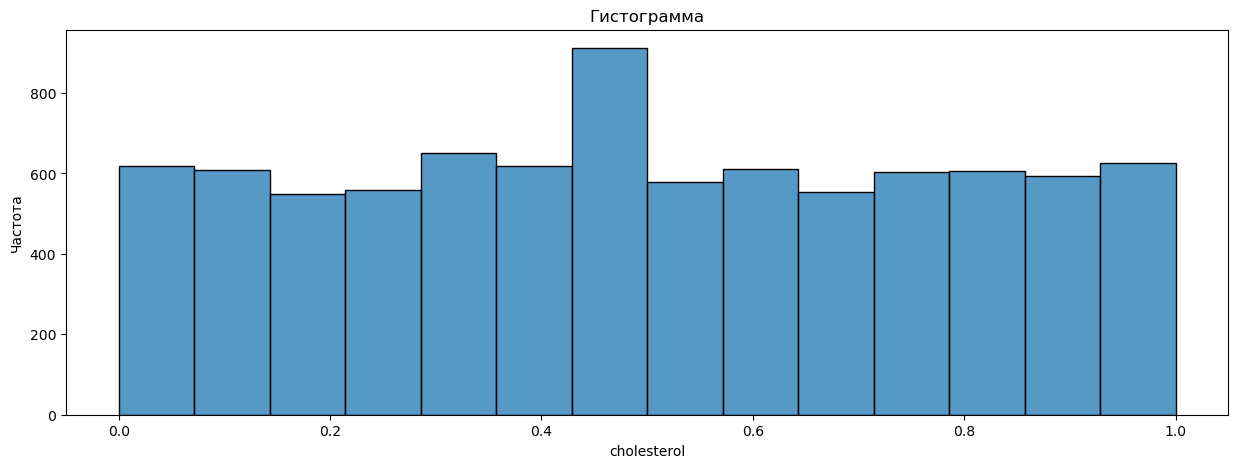

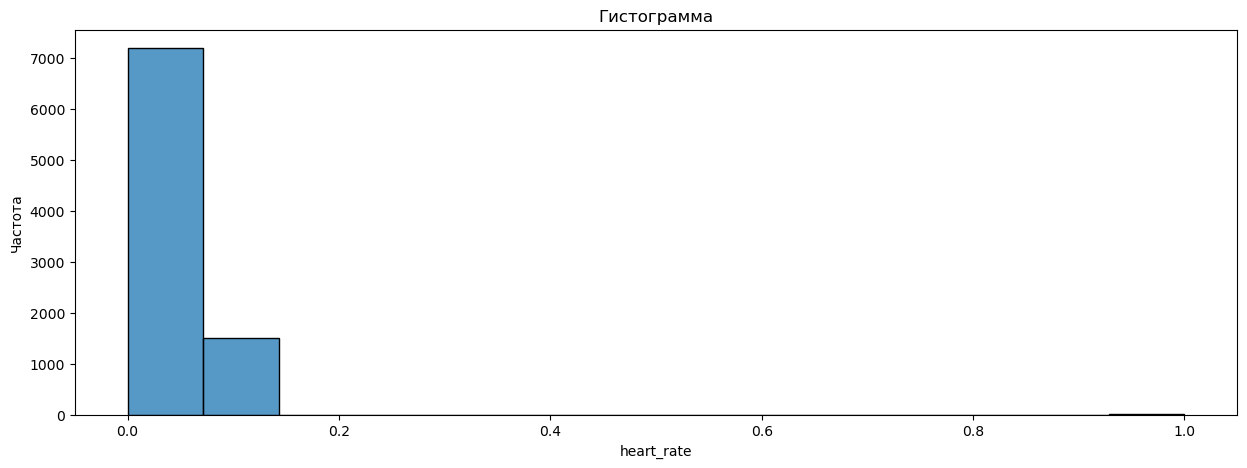

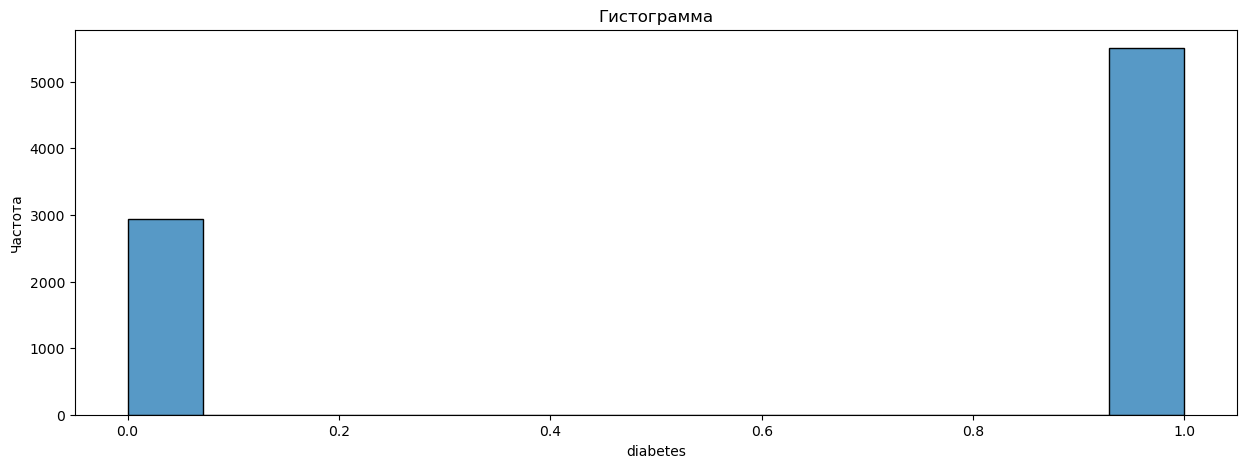

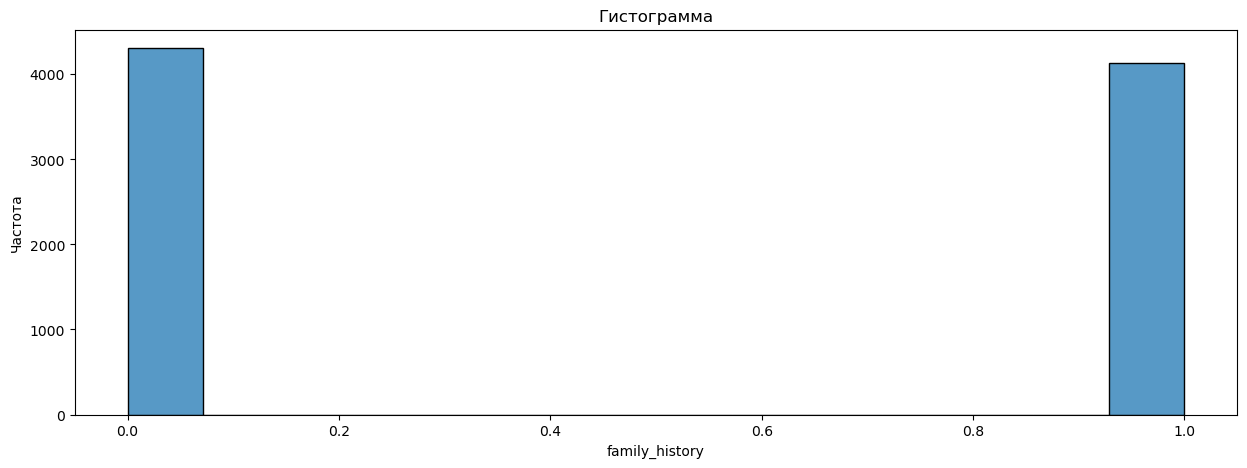

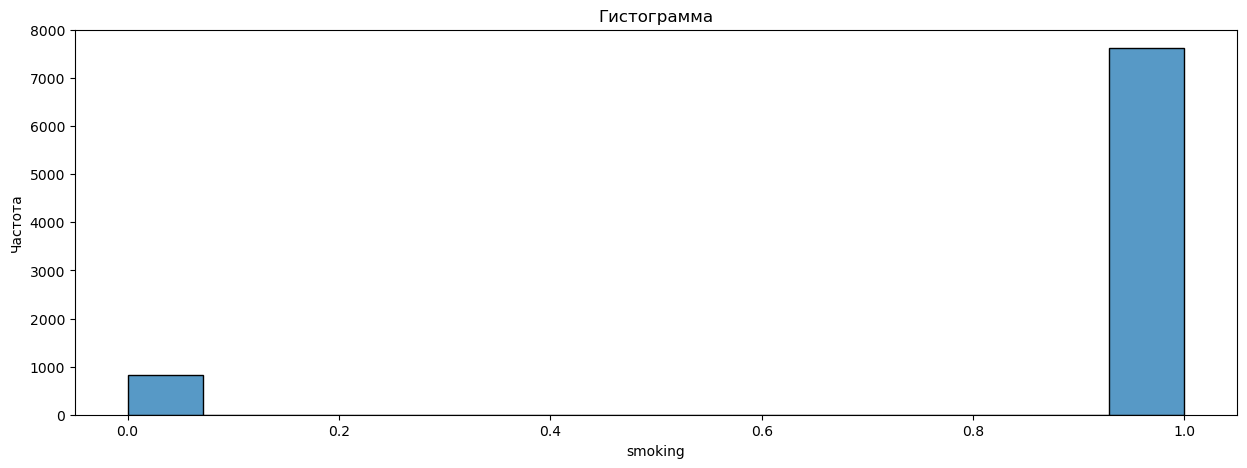

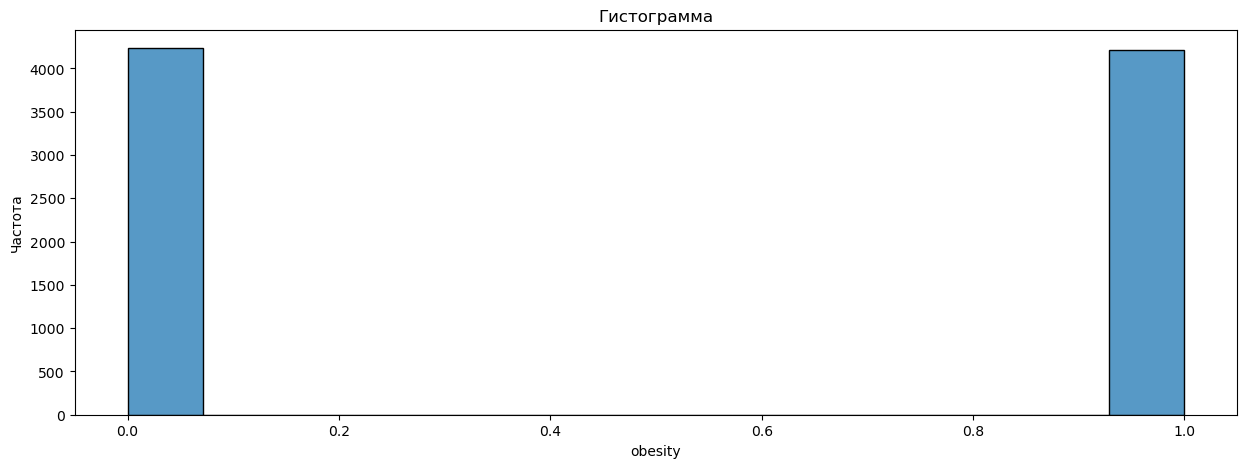

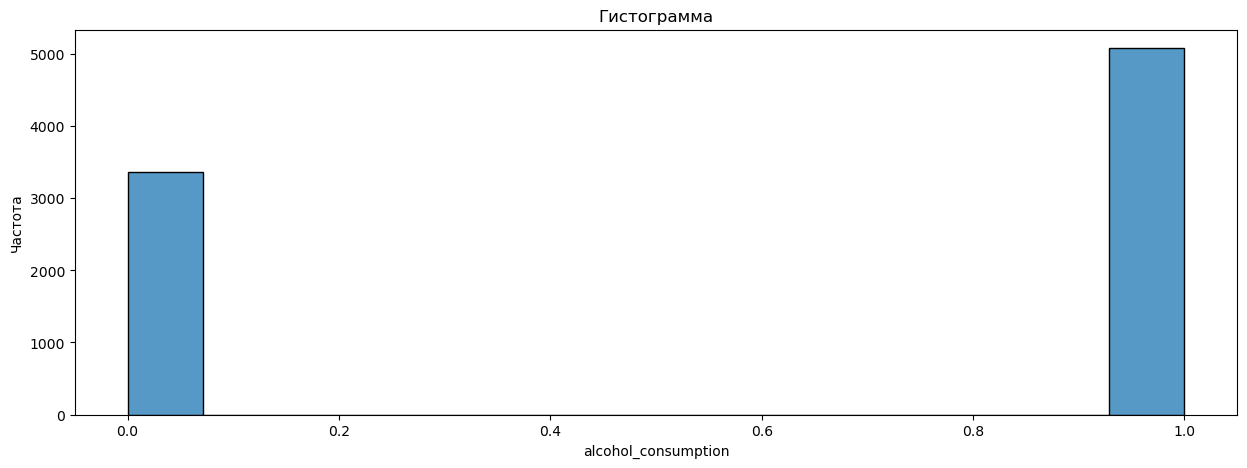

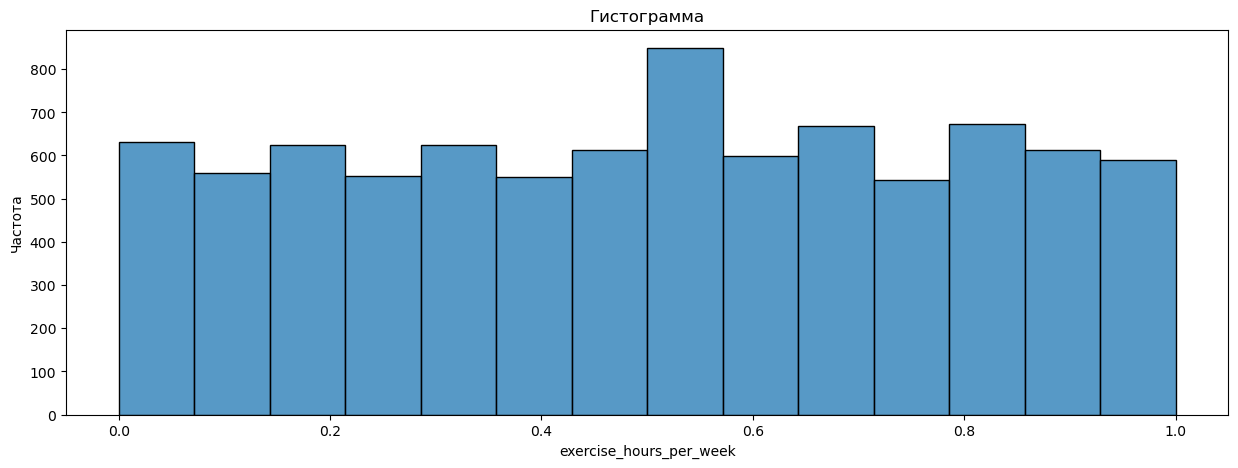

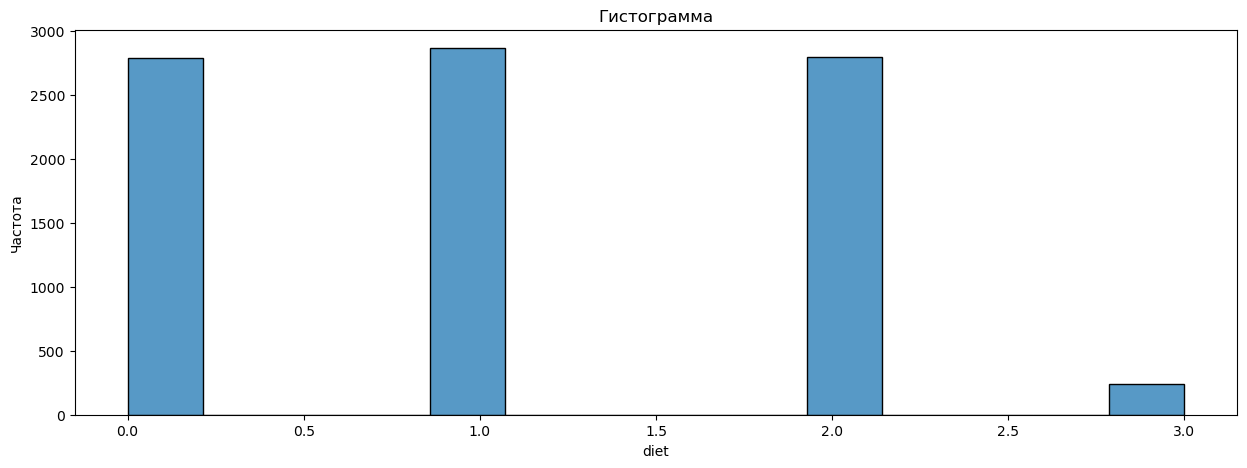

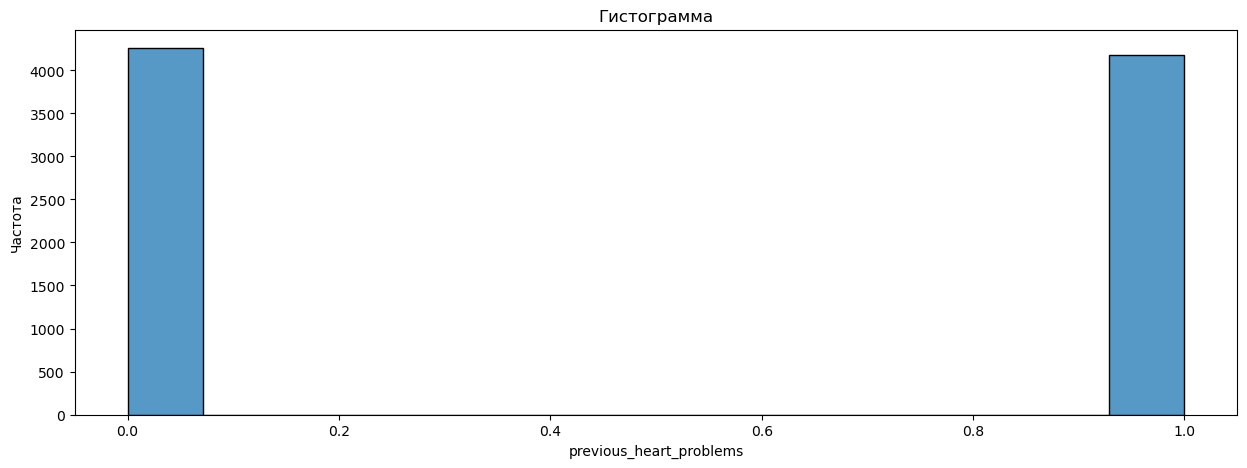

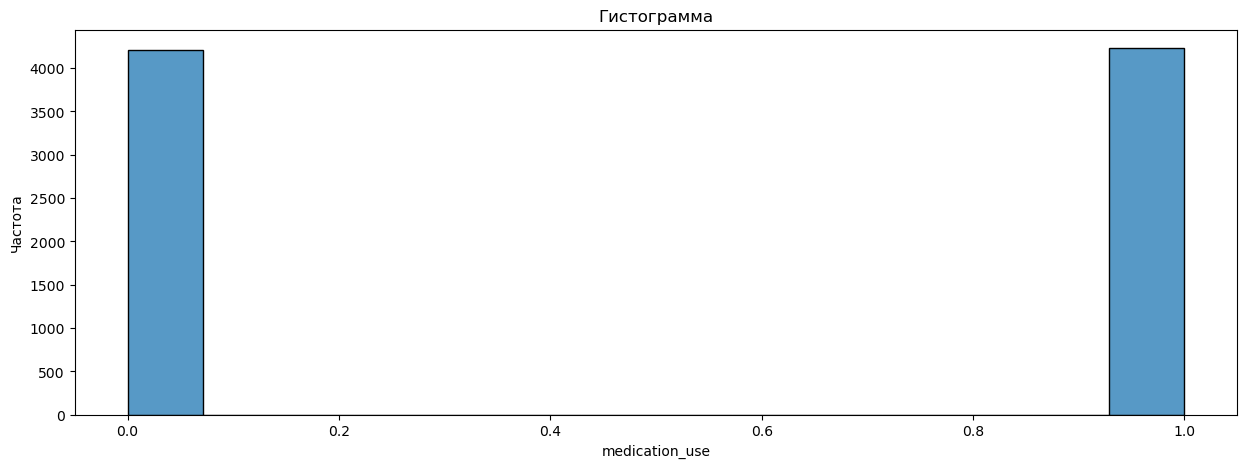

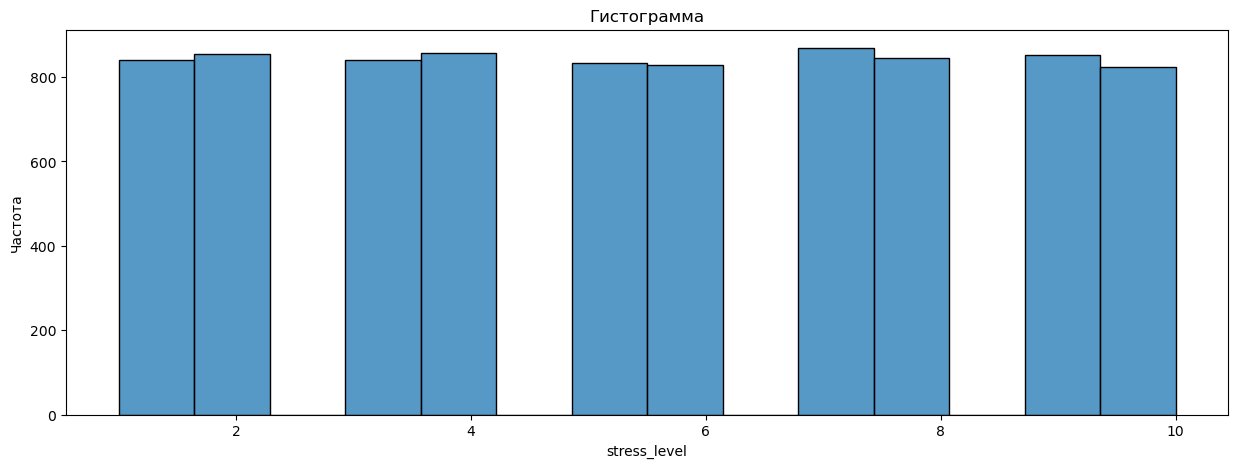

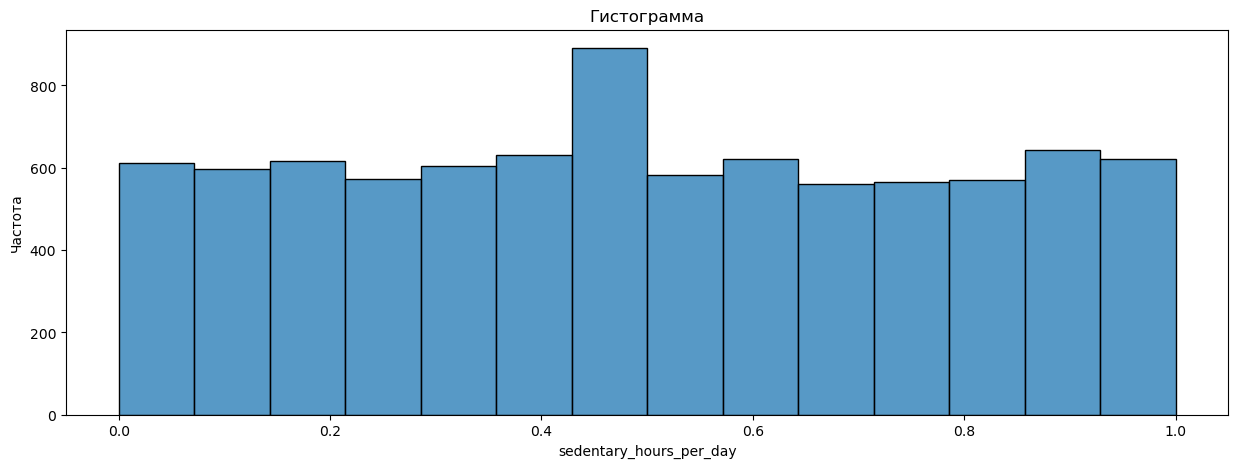

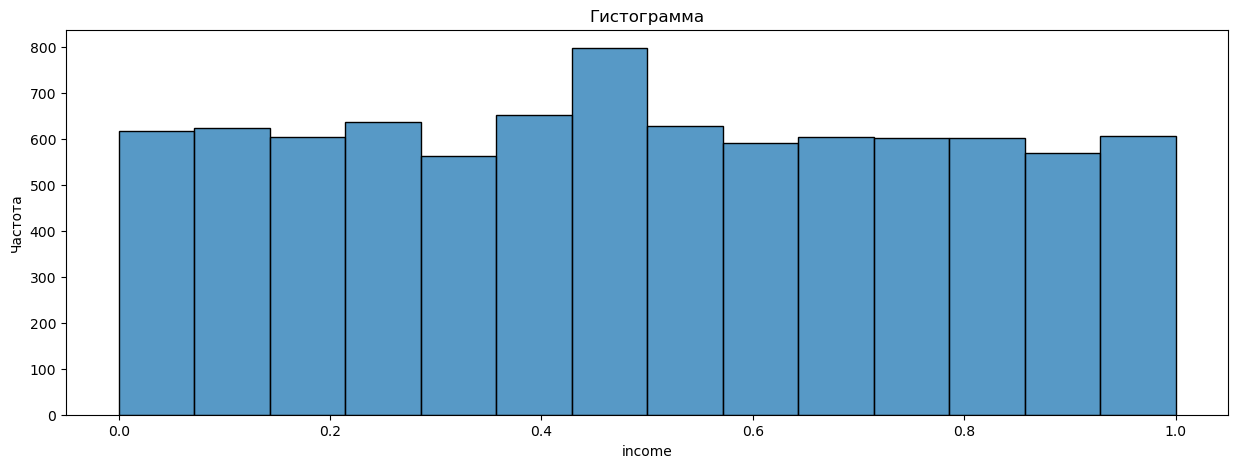

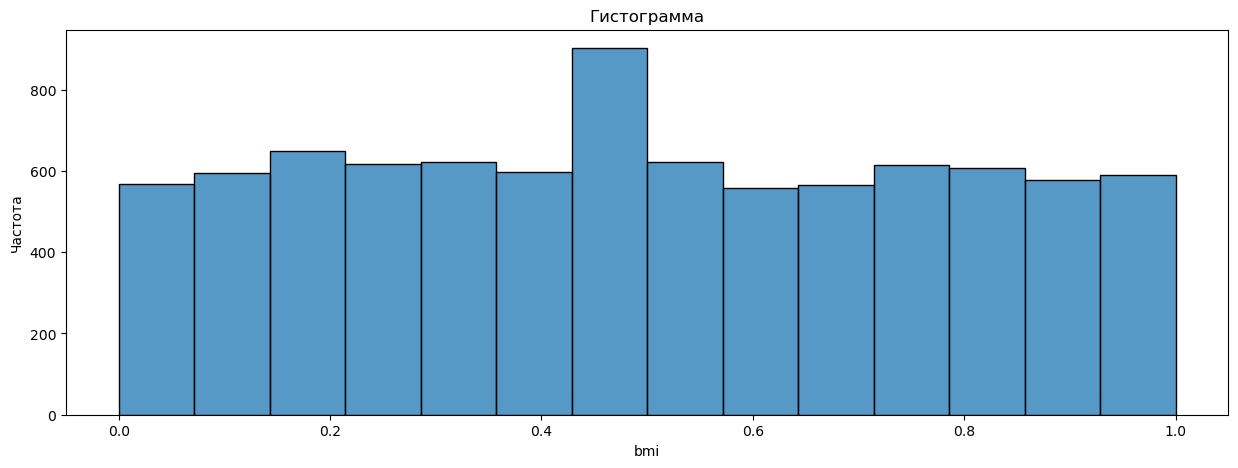

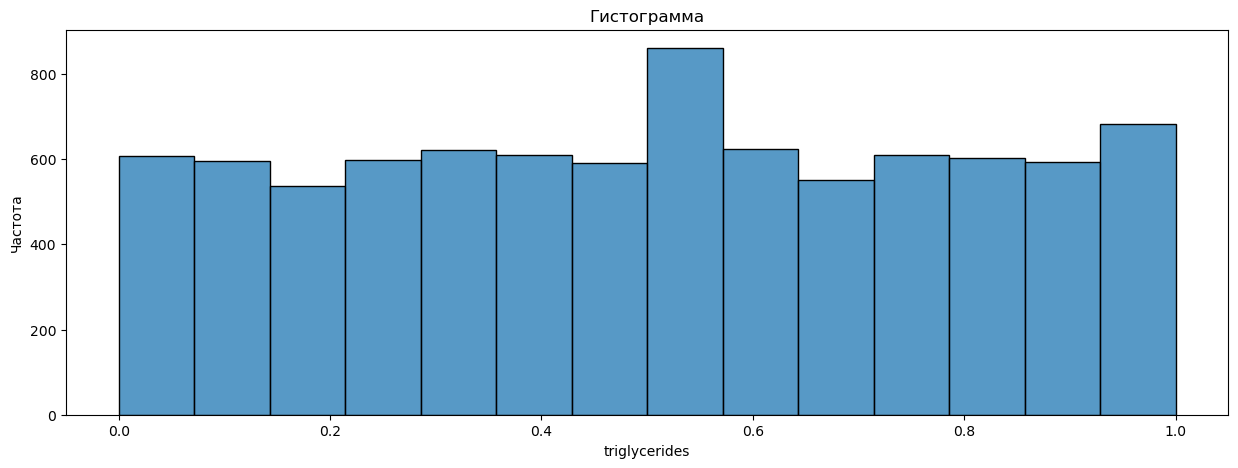

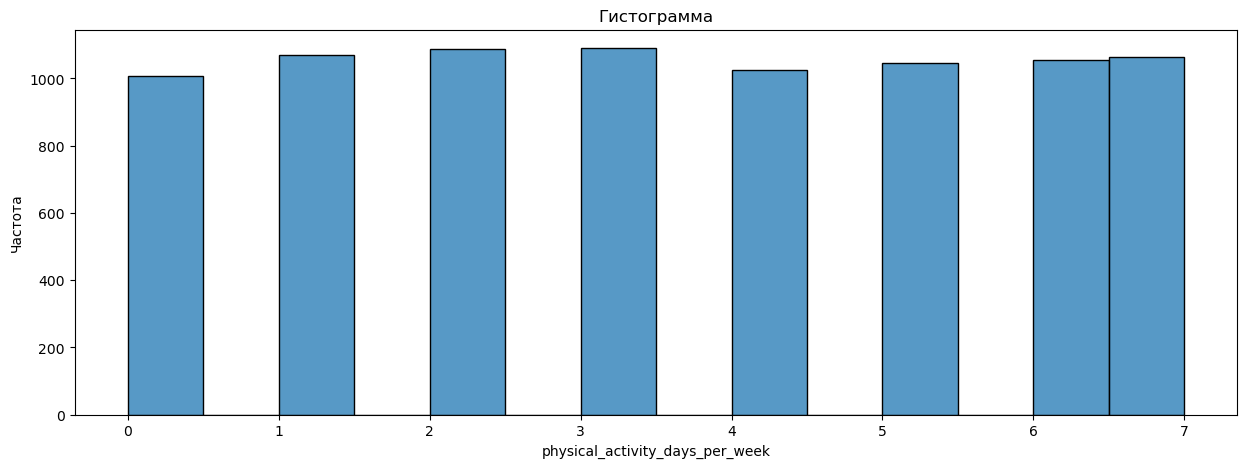

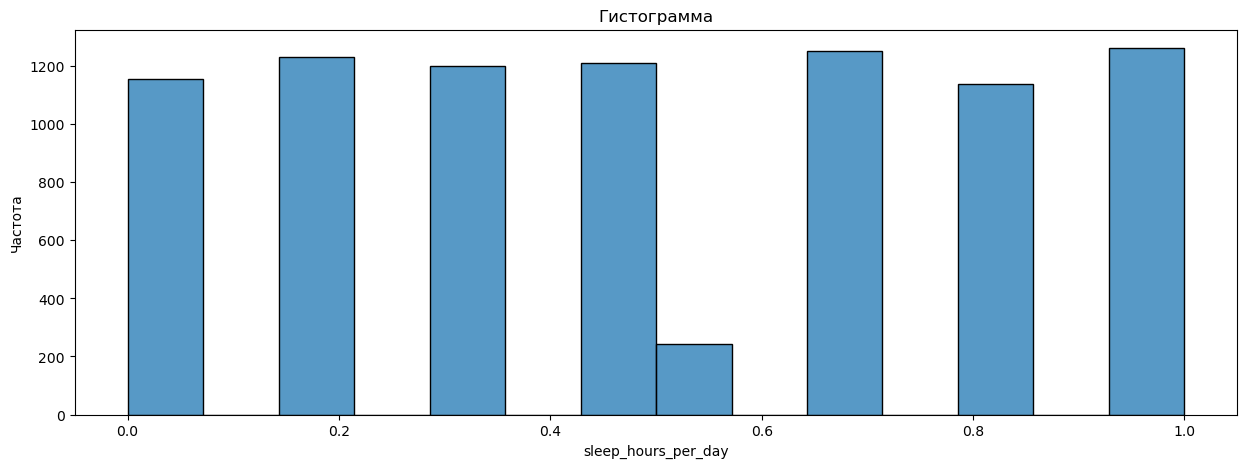

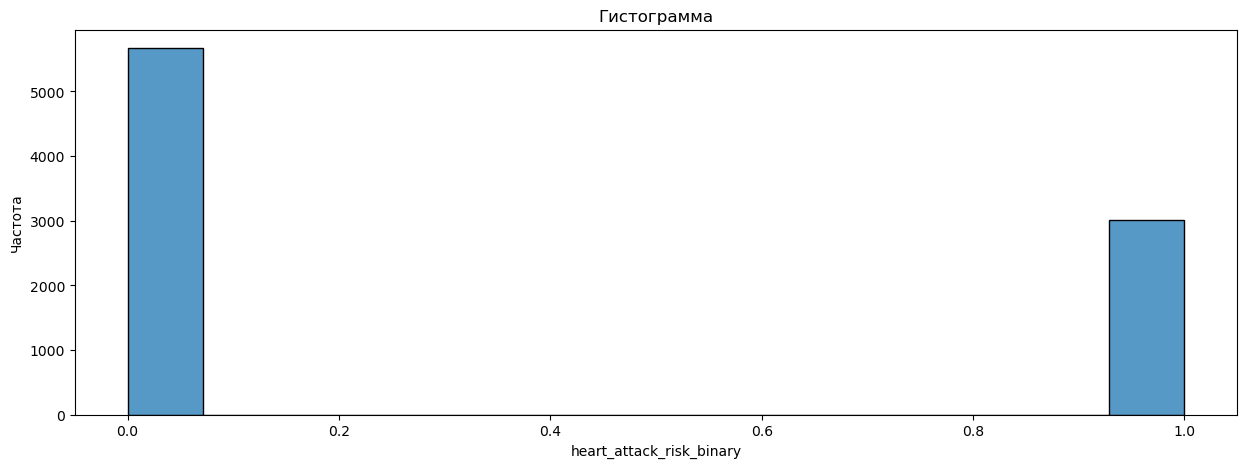

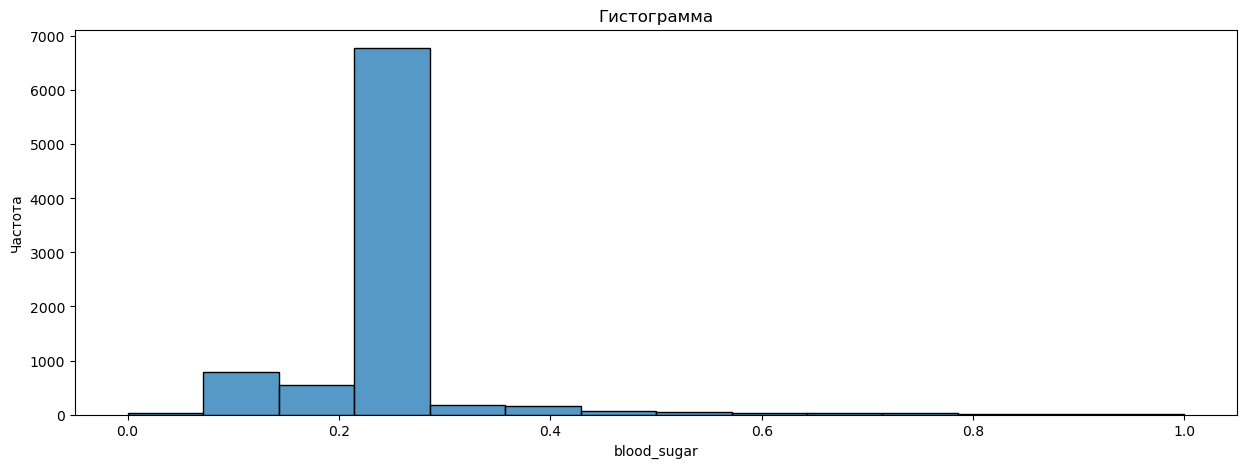

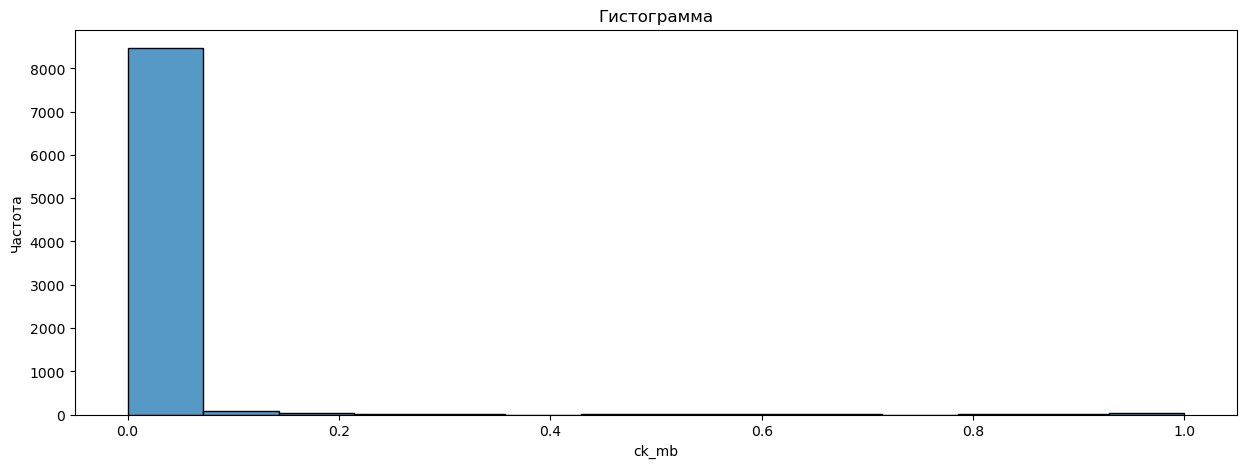

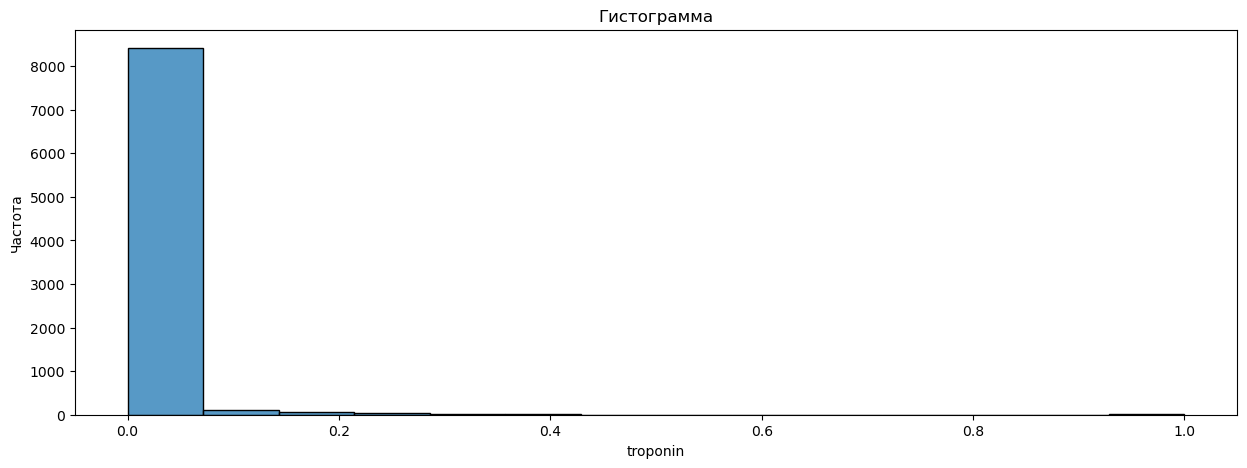

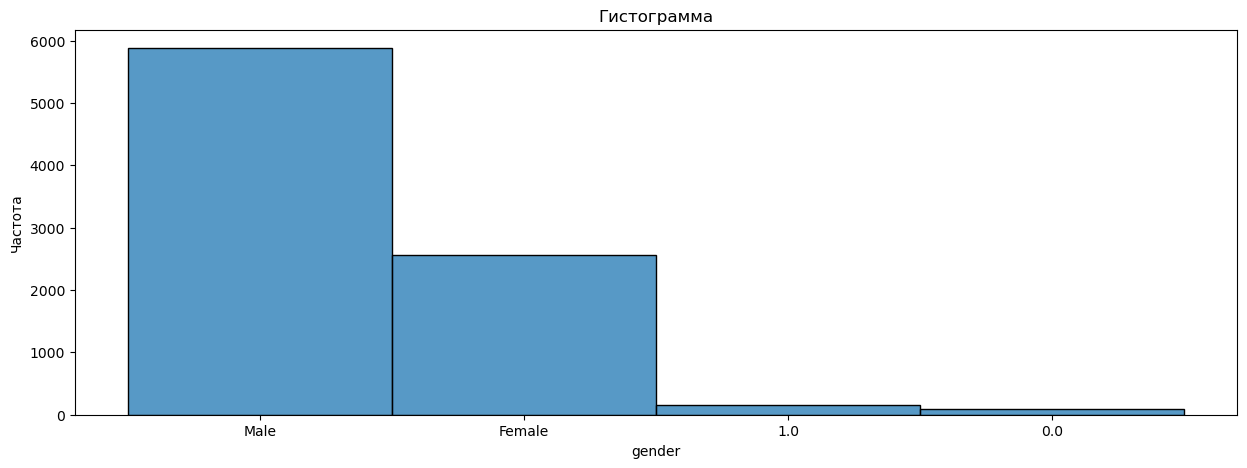

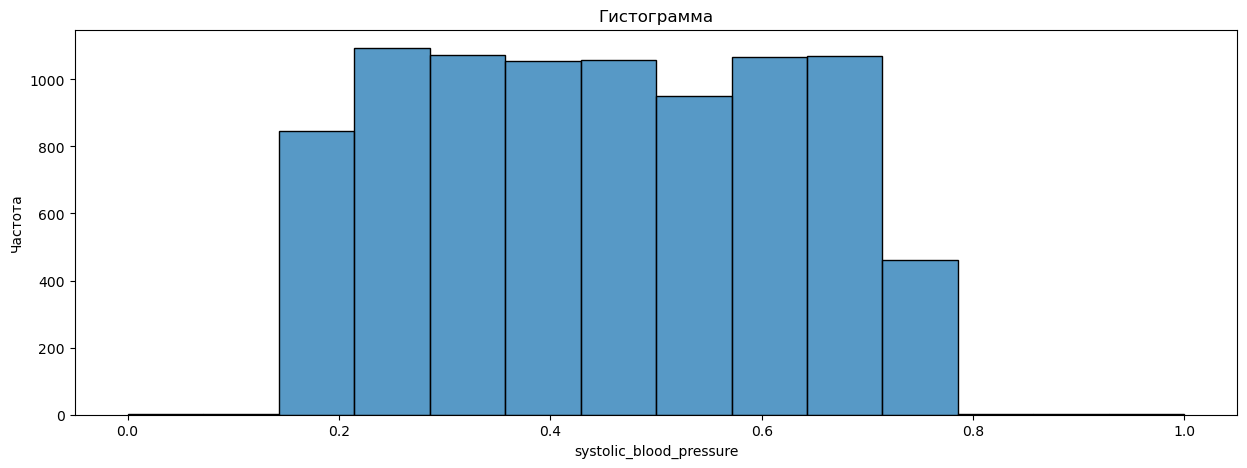

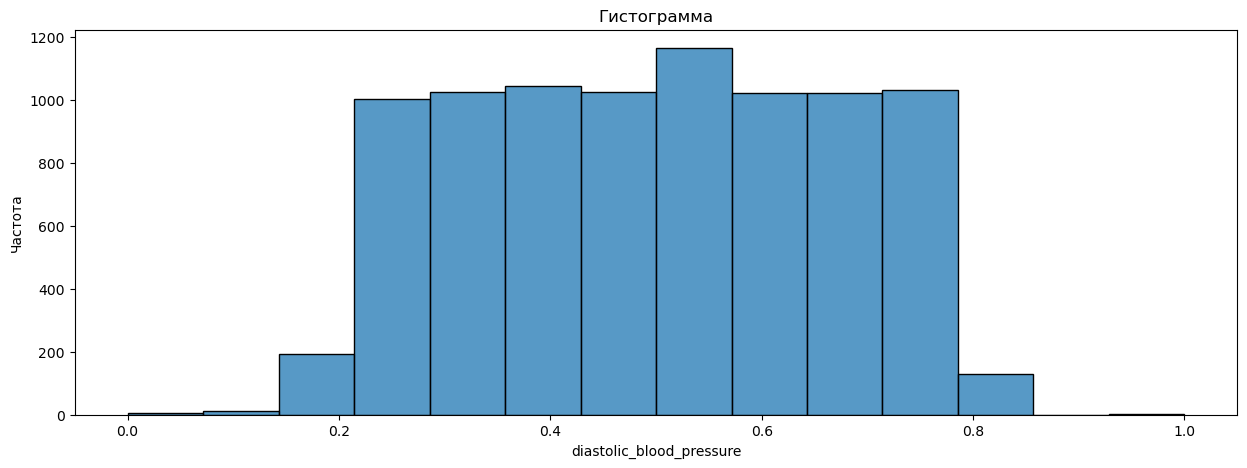

In [39]:
for col in train_data.columns:
    my_hist(train_data, col)

Наблюдаются выбросы в столбцах `heart_rate` и `troponin`. Хочется удалить их и заново провести нормализацию значений. Но неизвестно, как это скажется при оценке тестовой выборки. Откажемся от использования данных признаков.

In [41]:
def my_boxplot(df, x, y):
    plt.figure(figsize=(10,5))
    sns.boxplot(df, x=x, y=y)
    plt.title('Ящик с усами')
    plt.show()

Признак `gender` содержит в себе значения, представленные разными типами данных. В тестовом датасете предполагаются такие же ошибки. Необходимо организовать правило обработки таких случаев. Попробуем выявить тренды между признаком `gender` и другими признаками, чтобы выбрать правило для обработки.

In [43]:
merged = pd.DataFrame()
merged['1.0'] = train_data[train_data['gender'] == '1.0'].describe().loc['50%']
merged['0.0'] = train_data[train_data['gender'] == '0.0'].describe().loc['50%']
merged['Male'] = train_data[train_data['gender'] == 'Male'].describe().loc['50%']
merged['Female'] = train_data[train_data['gender'] == 'Female'].describe().loc['50%']
merged = merged.dropna(how='any')

merged['delta1'] = merged['1.0'] / merged['0.0'] - 1
merged['delta2'] = merged['Male'] / merged['Female'] - 1

merged['delta3'] = merged['1.0'] / merged['0.0'] - 1
merged['delta4'] = merged['Female'] / merged['Male'] - 1

display(merged[merged['delta1'] * merged['delta2'] > 0])
display(merged[merged['delta3'] * merged['delta4'] > 0])

,1.0,0.0,Male,Female,delta1,delta2,delta3,delta4
age,0.516854,0.494382,0.460674,0.449438,0.045455,0.025,0.045455,-0.02439


,1.0,0.0,Male,Female,delta1,delta2,delta3,delta4


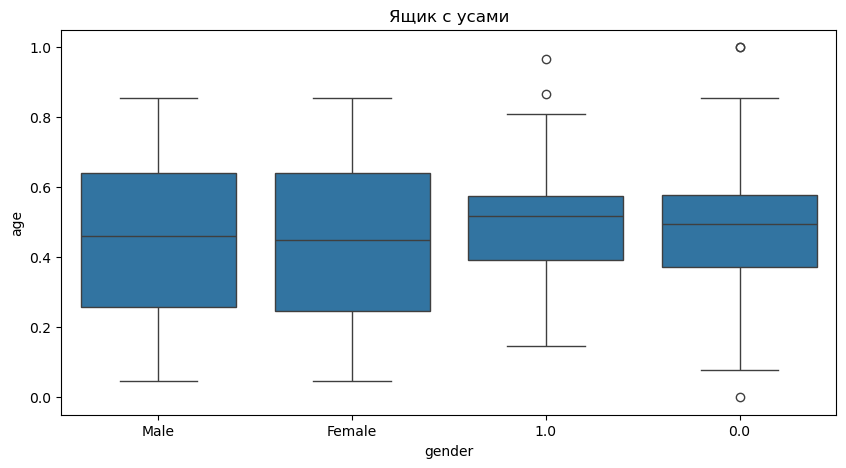

In [44]:
my_boxplot(train_data, 'gender', 'age')

Наблюдается небольшое сходство в сдвигах между медианными значениями (Male и 1.0) и (Female и 0.0). Приведем их к общим значениям. (Male и 1.0) = 1. (Female и 0.0) = 0.

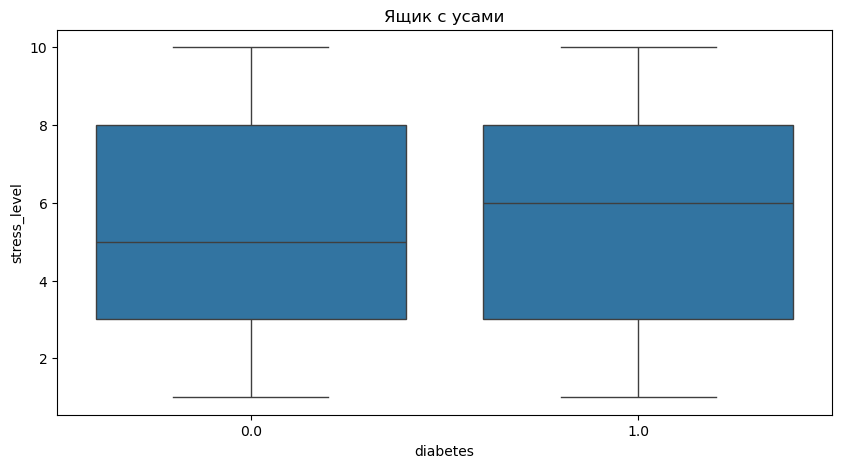

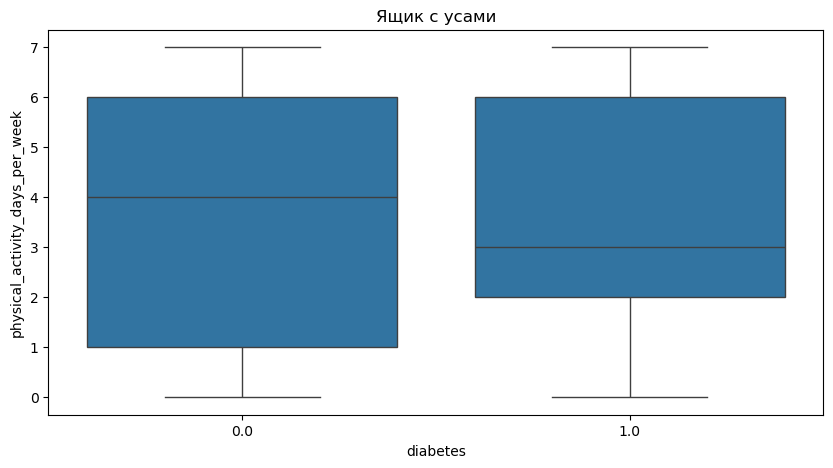

In [46]:
target_subject = 'diabetes'
for col in ['stress_level', 'physical_activity_days_per_week']:
    my_boxplot(train_data, target_subject, col)

Наблюдается определенная корреляция признака `diabetes` с признаками `stress_level` и `physical_activity_days_per_week`.

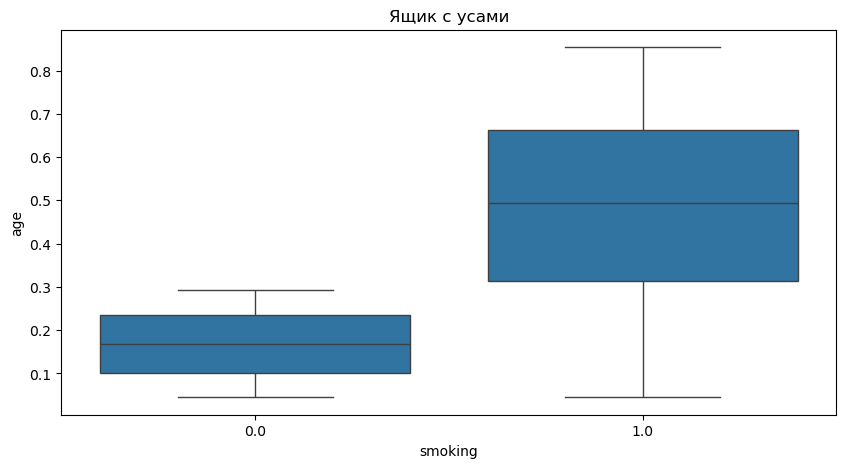

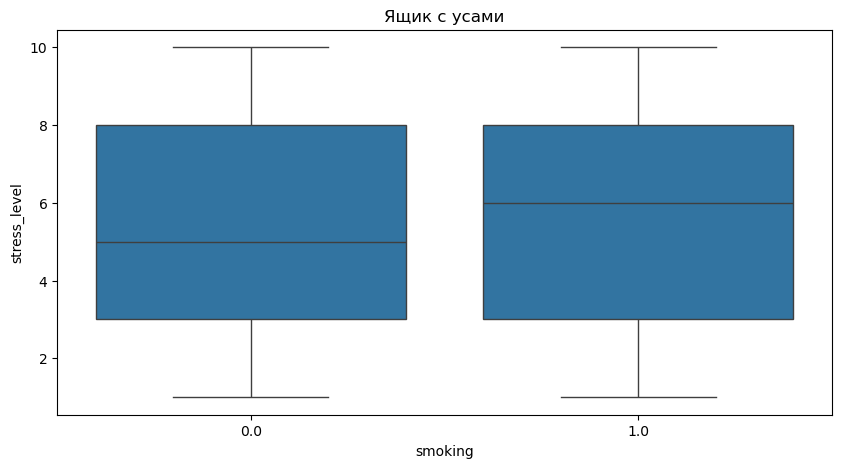

In [48]:
target_subject = 'smoking'
for col in ['age', 'stress_level']:
    my_boxplot(train_data, target_subject, col)

Наблюдается определенная корреляция признака `smoking` с признаками `age` и `stress_level`.

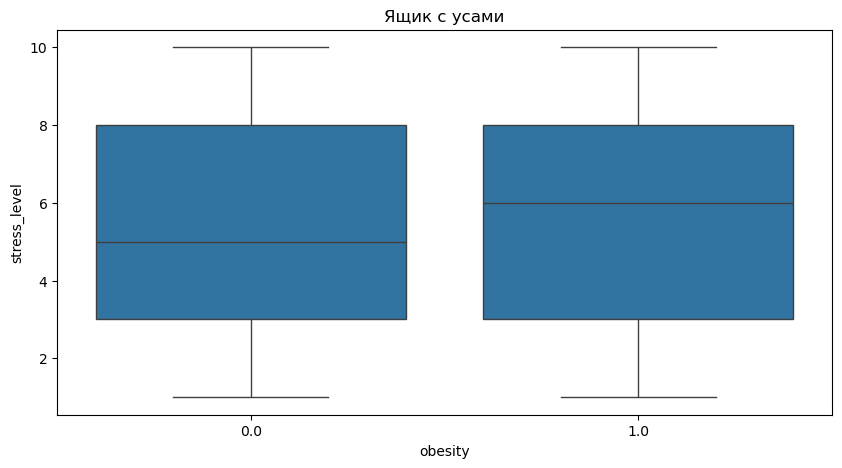

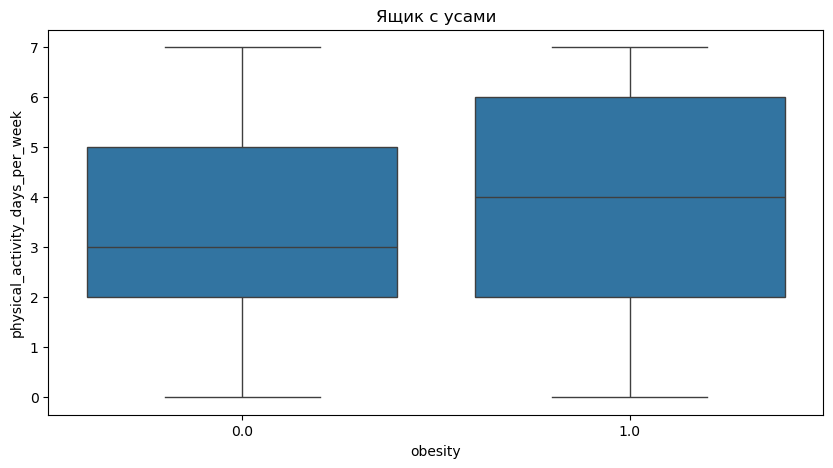

In [50]:
target_subject = 'obesity'
for col in ['stress_level', 'physical_activity_days_per_week']:
    my_boxplot(train_data, target_subject, col)

Наблюдается определенная корреляция признака `obesity` с признаками `stress_level` и `physical_activity_days_per_week`.

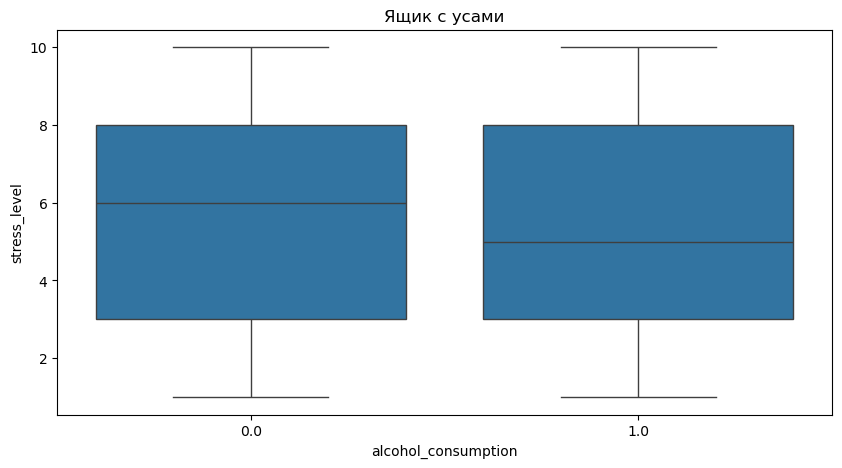

In [52]:
target_subject = 'alcohol_consumption'
for col in ['stress_level']:
    my_boxplot(train_data, target_subject, col)

Наблюдается определенная корреляция признака `alcohol_consumption` с признаками `stress_level`.

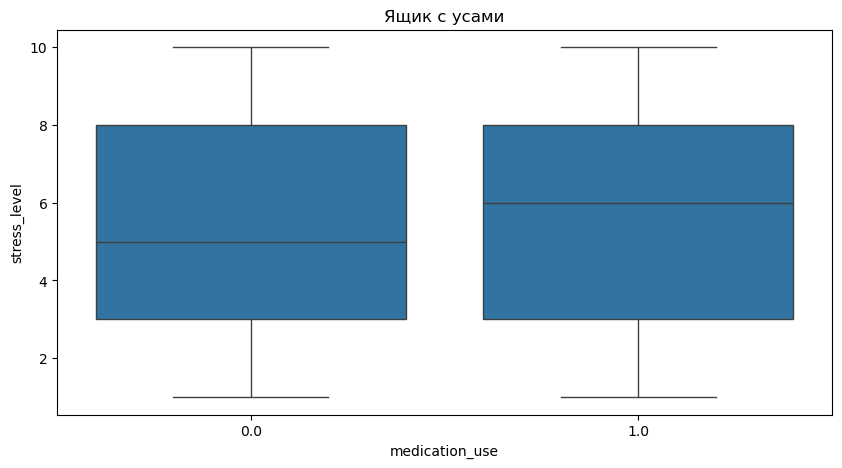

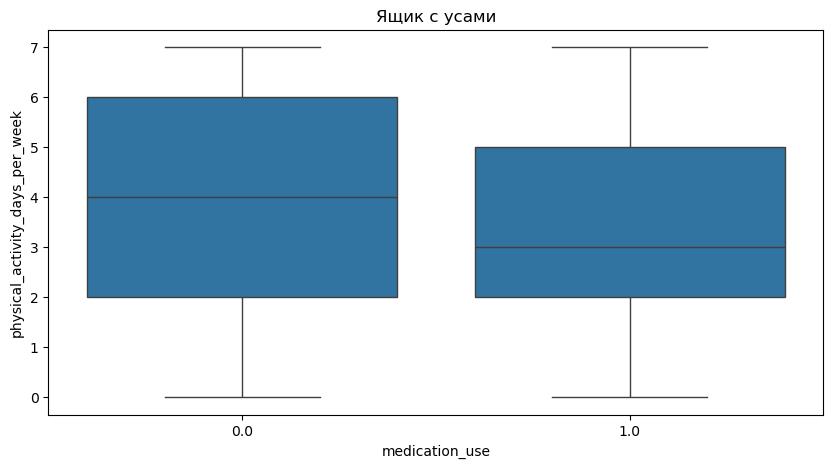

In [54]:
target_subject = 'medication_use'
for col in ['stress_level', 'physical_activity_days_per_week']:
    my_boxplot(train_data, target_subject, col)

Наблюдается определенная корреляция признака `medication_use` с признаками `stress_level` и `physical_activity_days_per_week`.

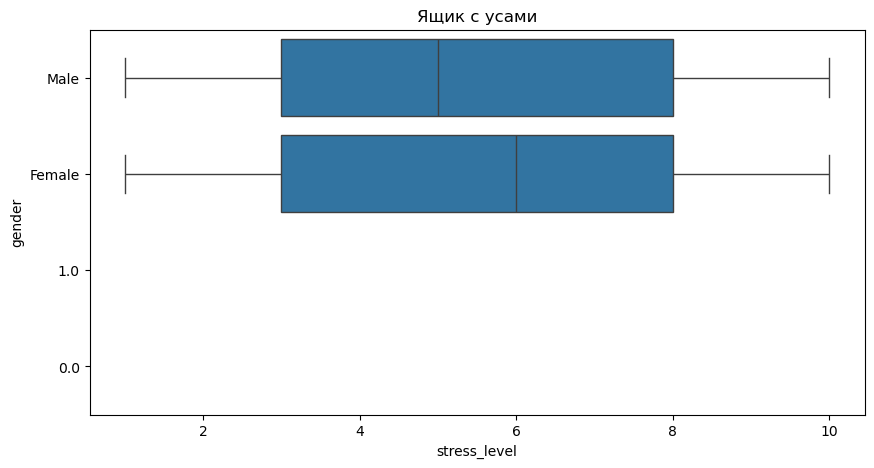

In [56]:
target_subject = 'stress_level'
for col in ['gender']:
    my_boxplot(train_data, target_subject, col)

Признак `stress_level` в основном коррелирует с признаком `gender`.

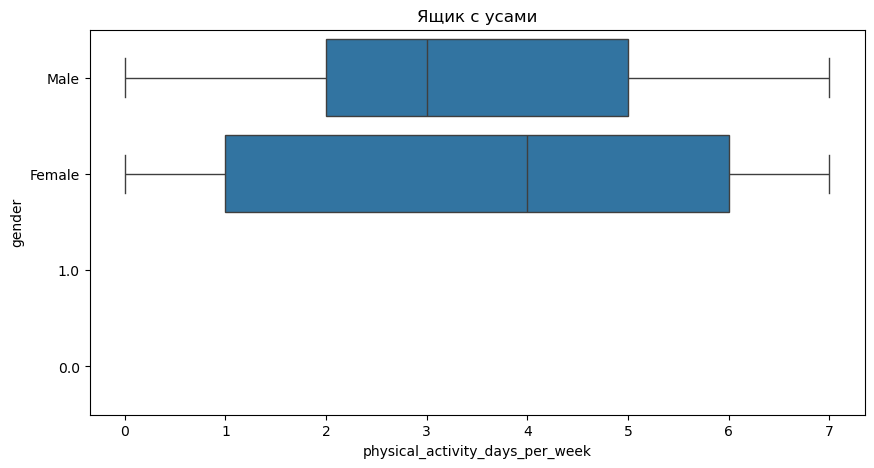

In [58]:
target_subject = 'physical_activity_days_per_week'
for col in ['gender']:
    my_boxplot(train_data, target_subject, col)

Признак `physical_activity_days_per_week` в основном коррелирует с признаком `gender`.

Итого: практически все признаки с пропусками коррелируют с признаками `stress_level` и `physical_activity_days_per_week`, которые в свою очередь коррелируют с признаком `gender`.

In [61]:
def fill_missing(row, missing_feature, important_feature, median_dic):
    result_row = row.copy()
    
    if np.isnan(result_row[missing_feature]):
        result_row[missing_feature] = median_dic[result_row[important_feature]]
        
    return result_row

In [62]:
def fill_missing_2d(row, missing_feature, important_features, median_dic):
    result_row = row.copy()
    
    if np.isnan(result_row[missing_feature]):
        f1 = result_row[important_features[0]]
        f2 = result_row[important_features[1]]
        result_row[missing_feature] = median_dic[f1][f2]
        
    return result_row

In [63]:
def preproc(df):
    result_df = df.copy()

    #удалим ненужные столбцы
    result_df.drop(columns=['family_history'], inplace=True)
    result_df.drop(columns=['diet'], inplace=True)
    result_df.drop(columns=['previous_heart_problems'], inplace=True)
    result_df.drop(columns=['troponin'], inplace=True)
    result_df.drop(columns=['income'], inplace=True)
    result_df.drop(columns=['heart_rate'], inplace=True)
    
    
    #обработаем признак gender
    pd.set_option('future.no_silent_downcasting', True)
    result_df['gender'] = result_df['gender'].replace({'Male': '1.0', 'Female': '0.0'}).astype(float)
    #заполним пропуски stress_level и physical_activity_days_per_week по gender
    for col in ['stress_level', 'physical_activity_days_per_week']:
        median_dic = result_df.groupby('gender')[col].median()
        result_df = result_df.apply(lambda x: fill_missing(x, col, 'gender', median_dic), axis=1)
    #заполним пропуски alcohol_consumption и smoking по stress_level
    for col in ['alcohol_consumption', 'smoking']:
        median_dic = result_df.groupby('stress_level')[col].median()
        result_df = result_df.apply(lambda x: fill_missing(x, col, 'stress_level', median_dic), axis=1)
    #заполним пропуски diabetes, obesity и medication_use по stress_level и physical_activity_days_per_week
    for col in ['diabetes', 'obesity', 'medication_use']:
        important_features = ['stress_level', 'physical_activity_days_per_week']
        median_dic = result_df.groupby(important_features)[col].median()
        result_df = result_df.apply(lambda x: fill_missing_2d(x, col, important_features, median_dic), axis=1)
        
    #признаковый инжениринг
    result_df['bad_health'] = result_df['triglycerides'] * \
                                (0.1 + result_df['alcohol_consumption'])  * \
                                (0.1 + result_df['smoking'])  * \
                                (0.1 + result_df['obesity']) * \
                                (0.1 + result_df['diabetes']) * \
                                (0.1 + result_df['sedentary_hours_per_day']) * \
                                result_df['bmi'] * \
                                result_df['cholesterol'] * \
                                result_df['age'] 
    result_df.drop(columns=['triglycerides'], inplace=True)
    result_df.drop(columns=['alcohol_consumption'], inplace=True)
    result_df.drop(columns=['smoking'], inplace=True)
    result_df.drop(columns=['obesity'], inplace=True)
    result_df.drop(columns=['diabetes'], inplace=True)
    result_df.drop(columns=['sedentary_hours_per_day'], inplace=True)
    result_df.drop(columns=['bmi'], inplace=True)
    result_df.drop(columns=['cholesterol'], inplace=True)
    result_df.drop(columns=['age'], inplace=True)
    
    result_df['good_health'] = result_df['exercise_hours_per_week'] * result_df['physical_activity_days_per_week'] * result_df['sleep_hours_per_day']
    result_df.drop(columns=['exercise_hours_per_week'], inplace=True)
    result_df.drop(columns=['physical_activity_days_per_week'], inplace=True)
    result_df.drop(columns=['sleep_hours_per_day'], inplace=True)
   
    return result_df

In [64]:
train_data = preproc(train_data)
train_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 8685 entries, 2664 to 7270
Data columns (total 10 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   medication_use            8685 non-null   float64
 1   stress_level              8685 non-null   float64
 2   heart_attack_risk_binary  8685 non-null   float64
 3   blood_sugar               8685 non-null   float64
 4   ck_mb                     8685 non-null   float64
 5   gender                    8685 non-null   float64
 6   systolic_blood_pressure   8685 non-null   float64
 7   diastolic_blood_pressure  8685 non-null   float64
 8   bad_health                8685 non-null   float64
 9   good_health               8685 non-null   float64
dtypes: float64(10)
memory usage: 746.4 KB


In [65]:
train_data.describe()

,medication_use,stress_level,heart_attack_risk_binary,blood_sugar,ck_mb,gender,systolic_blood_pressure,diastolic_blood_pressure,bad_health,good_health
count,8685.000000,8685.000000,8685.000000,8685.000000,8685.000000,8685.000000,8685.000000,8685.000000,8685.000000,8685.000000
mean,0.487162,5.489580,0.346920,0.227339,0.048159,0.695222,0.450295,0.497634,0.011618,0.898920
std,0.499864,2.828678,0.476017,0.076635,0.075531,0.460340,0.170184,0.171830,0.040433,1.157576
min,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,3.000000,0.000000,0.227018,0.048229,0.000000,0.303226,0.348837,0.000088,0.025176
50%,0.000000,5.000000,0.000000,0.227018,0.048229,1.000000,0.445161,0.500000,0.000718,0.462904
75%,1.000000,8.000000,1.000000,0.227018,0.048229,1.000000,0.600000,0.651163,0.005247,1.279925
max,1.000000,10.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.953698,6.947155


In [66]:
train_data.head()

,medication_use,stress_level,heart_attack_risk_binary,blood_sugar,ck_mb,gender,systolic_blood_pressure,diastolic_blood_pressure,bad_health,good_health
id,,,,,,,,,,
2664,0.0,8.0,0.0,0.227018,0.048229,1.0,0.212903,0.709302,5.644288e-02,0.535505
9287,0.0,9.0,0.0,0.150198,0.017616,0.0,0.412903,0.569767,1.871600e-05,0.171725
5379,1.0,6.0,0.0,0.227018,0.048229,0.0,0.238710,0.220930,2.411694e-03,1.888002
8222,1.0,3.0,1.0,0.227018,0.048229,0.0,0.348387,0.267442,1.774631e-07,0.000000
4047,0.0,8.0,1.0,0.227018,0.048229,1.0,0.619355,0.441860,2.583552e-04,2.064392


In [67]:
def my_heatmap(df, interval_cols):
    plt.figure(figsize=(15,10))
    sns.heatmap(
        df.phik_matrix(verbose=False, interval_cols=interval_cols), 
        annot=True, 
        fmt='.2f')
    plt.title('Матрица корреляции')
    plt.show()

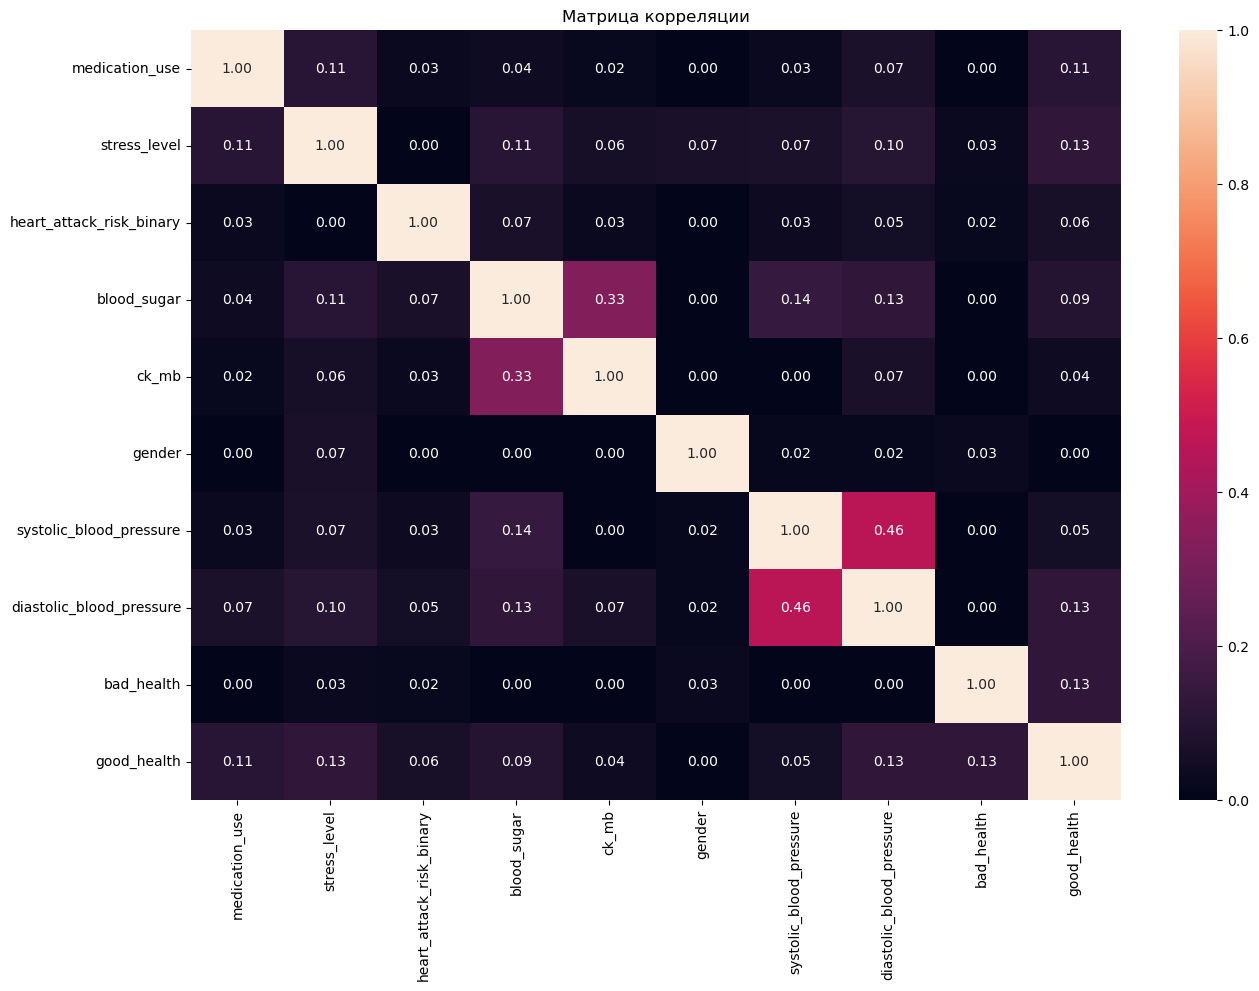

In [68]:
my_heatmap(train_data, None)

Высокая корреляция между входными признаками:
- `age` и `smoking`: 0.63
- `smoking` и `gender`: 0.69

Как правило, о мультиколлинеарности говорят при значении коэффициента корреляции от 0.9 до 0.95 по модулю. В нашем случае такой корреляции между входными признаками не обнаружено. Следовательно, будем считать, что мультиколлинеарность отсутствует. 

## Промежуточный вывод
По итогам изучения и обработки тренировочного датасета:
- Удален столбец, явно содержащий порядковую индексацию по умолчанию `Unnamed: 0`.
- Столбец `id` переведен в индексы датафрейма.
- Названия столбцов приведены к змеиному стилю.
- Из тренировочного датасеты были отброшены признаки:
    - `family_history` - бессмысленный признак
    - `diet` - возможна утечка
    - `previous_heart_problems` - возможна утечка
    - `troponin` - возможна утечка
    - `income` - бессмысленный признак
    - `heart_rate` - есть выбросы в заранее нормализованных данных
- Значения признака `gender` приведены к общему формату по следующему принципу:
    - "Male" = 1.0
    - "Female" = 0.0
    - "1.0" = 1.0
    - "0.0" = 0.0
- Пропуски в `stress_level` и `physical_activity_days_per_week` запонены медианным значением с учетом `gender`.
- Пропуски в `alcohol_consumption` и `smoking` запонены медианным значением с учетом `stress_level`.
- Пропуски в `diabetes`, `obesity` и `medication_use` запонены медианным значением с учетом `stress_level` и `physical_activity_days_per_week`.

В ходе работы с признаками:
- Объединены признаки `triglycerides`, `alcohol_consumption`, `smoking`, `obesity`, `diabetes`, `sedentary_hours_per_day`, `bmi`, `cholesterol`, `age` в признак `bad_health`.
- Объединены признаки `exercise_hours_per_week`, `physical_activity_days_per_week`, `sleep_hours_per_day` в признак `good_health`.

Высокая корреляция между входными признаками:
- `age` и `smoking`: 0.63
- `smoking` и `gender`: 0.69

Как правило, о мультиколлинеарности говорят при значении коэффициента корреляции от 0.9 до 0.95 по модулю. В нашем случае такой корреляции между входными признаками не обнаружено. Следовательно, будем считать, что мультиколлинеарность отсутствует. 

# Обучение моделей

In [72]:
X = train_data.drop(['heart_attack_risk_binary'], axis=1)
y = train_data['heart_attack_risk_binary']

X_train, X_val, y_train, y_val = train_test_split(
    X,
    y,
    test_size=TEST_SIZE, 
    random_state=RANDOM_STATE,
    stratify=y
)

pipe_final = Pipeline([
    ('models', DecisionTreeClassifier(random_state=RANDOM_STATE))
])

param_grid = [
    {
        'models': [DecisionTreeClassifier(random_state=RANDOM_STATE, class_weight='balanced')],
        'models__criterion': ['entropy'],
        'models__min_samples_leaf': [5],
        'models__max_depth': [10],
        'models__max_leaf_nodes': [10]
    }
]

grid = GridSearchCV(
    pipe_final, 
    param_grid=param_grid,
    cv=StratifiedKFold(n_splits=10, shuffle=True, random_state=RANDOM_STATE),
    scoring='recall',
    n_jobs=-1
)

grid.fit(X_train, y_train)

,estimator,Pipeline(step...m_state=42))])
,param_grid,"[{'models': [DecisionTreeC...ndom_state=42)], 'models__criterion': ['entropy'], 'models__max_depth': [10], 'models__max_leaf_nodes': [10], ...}]"
,scoring,'recall'
,n_jobs,-1
,refit,True
,cv,StratifiedKFo... shuffle=True)
,verbose,0
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,criterion,'entropy'


In [73]:
print('Лучшая модель и её параметры:\n\n', grid.best_estimator_)
print(f'Метрика лучшей модели на тренировочной выборке: {round(grid.best_score_, 3)}' )

Лучшая модель и её параметры:

 Pipeline(steps=[('models',
                 DecisionTreeClassifier(class_weight='balanced',
                                        criterion='entropy', max_depth=10,
                                        max_leaf_nodes=10, min_samples_leaf=5,
                                        random_state=42))])
Метрика лучшей модели на тренировочной выборке: 0.772


In [74]:
y_val_pred = grid.predict(X_val)
y_val_proba = grid.predict_proba(X_val)
print(f'Метрика accuracy на валидационной выборке: {round(accuracy_score(y_val, y_val_pred), 3)}')
print(f'Метрика f1 на валидационной выборке: {round(f1_score(y_val, y_val_pred), 3)}')
print(f'Метрика precision на валидационной выборке: {round(precision_score(y_val, y_val_pred), 3)}')
print(f'Метрика recall на валидационной выборке: {round(recall_score(y_val, y_val_pred), 3)}')
print(f'Метрика roc-auc на валидационной выборке: {round(roc_auc_score(y_val, y_val_proba[:,1]), 3)}')

Метрика accuracy на валидационной выборке: 0.409
Метрика f1 на валидационной выборке: 0.521
Метрика precision на валидационной выборке: 0.362
Метрика recall на валидационной выборке: 0.925
Метрика roc-auc на валидационной выборке: 0.539


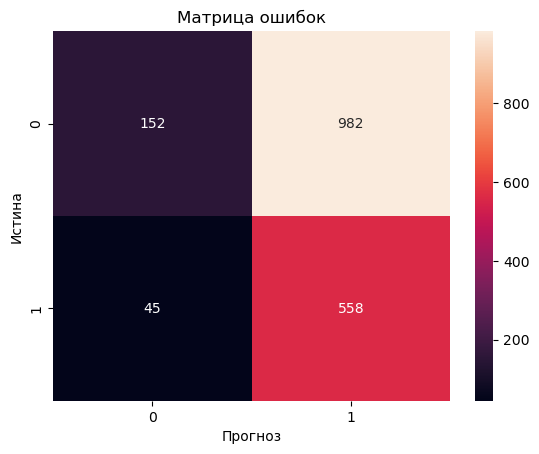

In [75]:
cm = pd.DataFrame(confusion_matrix(y_val, y_val_pred))
sns.heatmap(cm, annot=True, fmt='d');
plt.title('Матрица ошибок')
plt.ylabel('Истина')
plt.xlabel('Прогноз')
plt.show()

In [76]:
feature_importances = pd.DataFrame(
    {
        'Feature': grid.best_estimator_.feature_names_in_,
        'Importance': grid.best_estimator_._final_estimator.feature_importances_
    })
print(feature_importances.sort_values('Importance', ascending=False))

                    Feature  Importance
8               good_health    0.239668
1              stress_level    0.216364
6  diastolic_blood_pressure    0.182365
5   systolic_blood_pressure    0.169830
3                     ck_mb    0.100780
7                bad_health    0.090993
0            medication_use    0.000000
2               blood_sugar    0.000000
4                    gender    0.000000


In [77]:
#from joblib import dump, load
#dump(grid.best_estimator_, 'dtc_0521.joblib') 

['dtc_0521.joblib']

## Промежуточный вывод

По результатам перебора моделей классификации и их гиперпараметров была выбрана модель `DecisionTreeClassifier` как наиболее подходящая.

Метрики выбранной модели на валидационной выборке:
- `accuracy`: 0.409
- `f1`: 0.521
- `precision`: 0.362
- `recall`: 0.925
- `roc-auc`: 0.539

В качестве целевой метрики была выбрана `recall`, т.к. в случае диагностики сердечного приступа необходимо минимизировать случаи упущения пациентов из группы риска.

Анализ важности признаков показал следующее распределение признаков:
1. `good_health`: 0.239668
1. `stress_level`: 0.216364
1. `diastolic_blood_pressure`: 0.182365
1. `systolic_blood_pressure`: 0.169830
1. `ck_mb`: 0.100780
1. `bad_health`: 0.090993

# Итоги

## Подготовка данных
По итогам изучения и обработки тренировочного датасета:
- Удален столбец, явно содержащий порядковую индексацию по умолчанию `Unnamed: 0`.
- Столбец `id` переведен в индексы датафрейма.
- Названия столбцов приведены к змеиному стилю.
- Из тренировочного датасеты были отброшены признаки:
    - `family_history` - бессмысленный признак
    - `diet` - возможна утечка
    - `previous_heart_problems` - возможна утечка
    - `troponin` - возможна утечка
    - `income` - бессмысленный признак
    - `heart_rate` - есть выбросы в заранее нормализованных данных
- Значения признака `gender` приведены к общему формату по следующему принципу:
    - "Male" = 1.0
    - "Female" = 0.0
    - "1.0" = 1.0
    - "0.0" = 0.0
- Пропуски в `stress_level` и `physical_activity_days_per_week` запонены медианным значением с учетом `gender`.
- Пропуски в `alcohol_consumption` и `smoking` запонены медианным значением с учетом `stress_level`.
- Пропуски в `diabetes`, `obesity` и `medication_use` запонены медианным значением с учетом `stress_level` и `physical_activity_days_per_week`.

В ходе работы с признаками:
- Объединены признаки `triglycerides`, `alcohol_consumption`, `smoking`, `obesity`, `diabetes`, `sedentary_hours_per_day`, `bmi`, `cholesterol`, `age` в признак `bad_health`.
- Объединены признаки `exercise_hours_per_week`, `physical_activity_days_per_week`, `sleep_hours_per_day` в признак `good_health`.

Высокая корреляция между входными признаками:
- `age` и `smoking`: 0.63
- `smoking` и `gender`: 0.69

Как правило, о мультиколлинеарности говорят при значении коэффициента корреляции от 0.9 до 0.95 по модулю. В нашем случае такой корреляции между входными признаками не обнаружено. Следовательно, будем считать, что мультиколлинеарность отсутствует. 

## Обучение моделей
По результатам перебора моделей классификации и их гиперпараметров была выбрана модель `DecisionTreeClassifier` как наиболее подходящая.

Метрики выбранной модели на валидационной выборке:

- `accuracy`: 0.409
- `f1`: 0.521
- `precision`: 0.362
- `recall`: 0.925
- `roc-auc`: 0.539

В качестве целевой метрики была выбрана `recall`, т.к. в случае диагностики сердечного приступа необходимо минимизировать случаи упущения пациентов из группы риска.

Анализ важности признаков показал следующее распределение признаков:

1. `good_health`: 0.239668
1. `stress_level`: 0.216364
1. `diastolic_blood_pressure`: 0.182365
1. `systolic_blood_pressure`: 0.169830
1. `ck_mb`: 0.100780
1. `bad_health`: 0.090993